# Metropolis-Hastings MCMC implementation (Python)

In [2]:
import numpy as np
from numpy import power as p 
from numpy import log
import matplotlib.pyplot as plt
import corner


### Create mock data

The mock data we will create is drawn from the distribution $f$ which has PDF 
$$f(v| v_{esc},k) = \frac{k+1}{v_{esc}{}^{k+1}} (v_{esc} - v)^k \quad,\quad v\in[0,v_{esc}]$$

and CDF
$$ \text{CDF}_f(v) =  \left( 1 - \frac{v}{v_{esc}} \right)^{k+1} -1 \quad,\quad v\in[0,v_{esc}]$$

which has inverse 
$$  \text{CDF}_f{}^{-1}(y) = v_{esc}\left[ 1 - (1-y)^{\frac{1}{k+1}}  \right] \quad,\quad y\in[0,1] $$

We need the inverse CDF to generate samples from this distribution. Note also that the log likelihood is given by
$$ Log\left(\text{Likelihood} (D|v_{esc},k)  \right) = \sum_d Log(f(d|vesc,k)  ) $$

for a dataset D consisting of datapoints $d$, where each term is of the form
$$  Log(f(d|vesc,k)  ) =  Log(k+1) - (k+1)Log(v_{esc}) + k~Log(v_{esc} - v) $$

In [3]:
def powerlaw_PDF(v,x):
    vesc,k = x
    return ( (k+1)*p(vesc,-k-1) ) * p(vesc - v, k)

def powerlaw_inverse_CDF(y,x):
    vesc,k = x
    return vesc*( 1.0 - p( 1.0-y, 1.0/(k+1.0)) )

### Define helper functions

In [4]:
def generate_samples(N,inverse_CDF,x):
    # To sample from a distribution we perform inverse transform sampling, for which the inverse CDF is required
    return inverse_CDF(np.random.uniform(size=N),x)

### Sample from distribution to obtain data which we will fit via MCMC

We generate data with a specific escape velocity and $k$ to use in our parameter fit later

In [5]:
target_vesc = 550.0
target_k = 3.0
target_x = [target_vesc,target_k]
num_samples = 1000

target_data = generate_samples(num_samples,powerlaw_inverse_CDF,target_x)

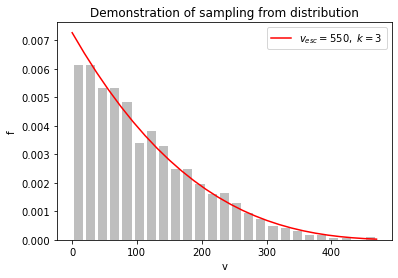

In [6]:
heights, bins, _ = plt.hist(target_data, bins=25, density=True, alpha=0.5,rwidth=0.75,color='C7')
plt.plot(bins, powerlaw_PDF(bins,target_x),color='red',label=r"$v_{esc}=550,~k=3$")
plt.title("Demonstration of sampling from distribution")
plt.xlabel("v")
plt.ylabel("f")
plt.legend()

# Define affine-invariant MCMC functions and parameters

In [7]:
def log_prior(x):
    vesc,k = x
    if 100 < vesc < 800 and 0.2 < k < 10 :
        return 0.0
    return -np.inf

def log_likelihood(x,data):
    vesc,k = x
    sum = 0
    for v in data:
        if v < vesc:
            sum += log(k+1) - (k+1)*log(vesc) + k*log(vesc - v)
        else:
            return -np.inf

    return sum 

def log_probability(x,data):
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(x,data)


# Use emcee for affine-invariant MCMC, set up sampler

In [8]:
import emcee
ndim = 2    # we nave 2 parameters
nwalkers = 10
x0 = np.random.rand(nwalkers, ndim)

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[target_data])

# Run MCMC analysis

In [18]:
np.max(target_data)

469.71854562380264

In [10]:
burnin = 200
num_steps = 5000

guess_vesc = 400
guess_k = 4

initial_guess_onewalker = np.array([guess_vesc,guess_k])
initial_guess = np.stack( [initial_guess_onewalker + np.random.normal([guess_vesc,guess_k],[90,0.9],(2,))  for _ in range(nwalkers)], axis=0 ) # Initial position for each walker randomly chosen close to initial guess

quantile_list = [0.16, 0.5, 0.84]

### Perform burn-in

In [11]:
state = sampler.run_mcmc(initial_guess, burnin,progress=True)
samples = sampler.get_chain(flat=True)

  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\CianM\anaconda3\envs\py3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


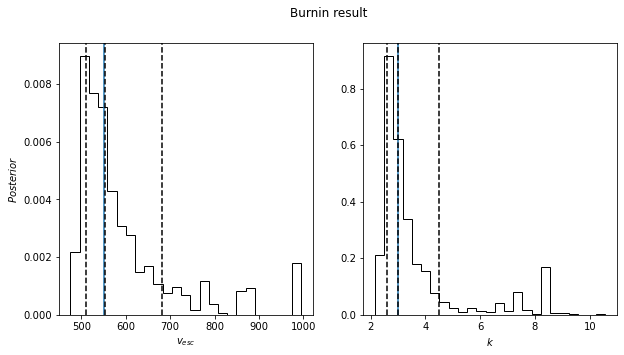

In [12]:
fig,axs=plt.subplots(ncols=2,figsize=(10,5))

fig.suptitle("Burnin result")

axs[0].hist(samples[:, 0], 25, color="k", histtype="step",density=True)
axs[0].set_xlabel(r"$v_{esc}$")
axs[0].set_ylabel(r"$Posterior$")
axs[0].axvline(x=target_vesc)
for quantile in quantile_list:
    axs[0].axvline( x=np.quantile(samples[:,0],quantile) , ls="--" , color='black' )

axs[1].hist(samples[:, 1], 25, color="k", histtype="step",density=True)
axs[1].set_xlabel(r"$k$")
axs[1].axvline(x=target_k)
for quantile in quantile_list:
    axs[1].axvline( x=np.quantile(samples[:,1],quantile) , ls="--" , color='black' )

### Perform actual MCMC run

In [13]:
sampler.reset()
sampler.run_mcmc(state, num_steps,progress=True)
samples = sampler.get_chain(flat=True)

100%|██████████| 5000/5000 [07:15<00:00, 11.49it/s]


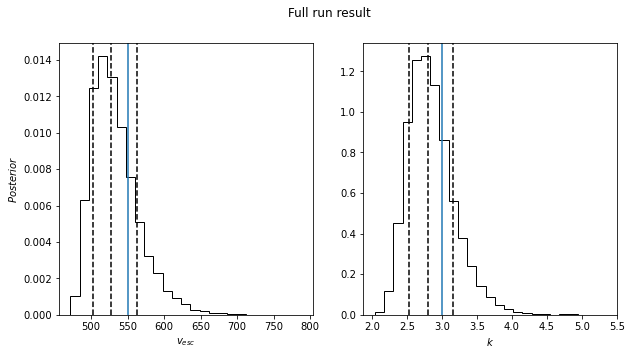

In [14]:
fig,axs=plt.subplots(ncols=2,figsize=(10,5))

fig.suptitle("Full run result")

axs[0].hist(samples[:, 0], 25, color="k", histtype="step",density=True)
axs[0].set_xlabel(r"$v_{esc}$")
axs[0].set_ylabel(r"$Posterior$")
axs[0].axvline(x=target_vesc)
for quantile in quantile_list:
    axs[0].axvline( x=np.quantile(samples[:,0],quantile) , ls="--" , color='black' )

axs[1].hist(samples[:, 1], 25, color="k", histtype="step",density=True)
axs[1].set_xlabel(r"$k$")
axs[1].axvline(x=target_k)
for quantile in quantile_list:
    axs[1].axvline( x=np.quantile(samples[:,1],quantile) , ls="--" , color='black' )

# Examine results closely

Autocorrelation time:

In [15]:
tau = sampler.get_autocorr_time()
print(tau)

[40.2200519  39.88948429]


which implies a burnin of 200 steps is very reasonable, if conservative

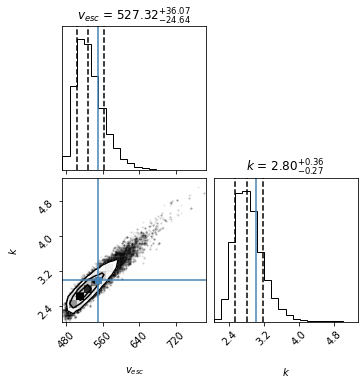

In [16]:
fig = corner.corner(
    samples, labels=[r"$v_{esc}$",r'$k$'], truths=[target_vesc, target_k], quantiles=quantile_list,
                       show_titles=True, title_kwargs={"fontsize": 12}
)

### Result obtained in 3 minutes for 1000 data points and 50000 steps (10 walkers * 5000 steps)
That is, roughly 26 iterations per second